In [1]:
import os
import argparse
import sys
from random import shuffle
from glob import glob

import tensorflow as tf
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

sys.path.append('..')
from models.config import Config
from models.utils import build_dataset
from models.utils import encode_string
from models.spacer import Spacer

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [2]:
class TrainingConfig(Config):
    BATCH_SIZE = 256
    FILTER_SIZES = [4, 6, 8, 10]
    FILTER_NUMS = [256, 256, 256, 256]
    EPOCHS = 3

config = TrainingConfig()

In [3]:
gpu_nums = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
if gpu_nums > 1:
    # Multi-GPU training.
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = Spacer(None,
                       config)
        optimizer = optimizers.Adam(config.LEARNING_RATE,
                                    False)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy',
                               tf.metrics.Precision(),
                               tf.metrics.Recall(),
                               tf.metrics.AUC()])
else:
    # Single GPU training.
    model = Spacer(None,
                   config) 
    optimizer = optimizers.Adam(config.LEARNING_RATE,
                                False)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy',
                           tf.metrics.Precision(),
                           tf.metrics.Recall(),
                           tf.metrics.AUC()])
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [4]:
# Data preparation
filenames = glob(os.path.join('../data/sejong_corpus', '*.txt'))
shuffle(filenames)

validation_split = int(len(filenames) * 0.2)
val_filenames = filenames[:validation_split]
train_filenames =  filenames[validation_split:]

print('Found {} files.'.format(len(filenames)))
print('Using {} files for training.'.format(len(train_filenames)))

Found 2226 files.
Using 1781 files for training.


In [5]:
X_train, y_train = build_dataset(train_filenames, config) 
X_val, y_val = build_dataset(val_filenames, config)
 
global_batch_size = config.BATCH_SIZE * gpu_nums
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(global_batch_size)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
valid_dataset = valid_dataset.batch(global_batch_size)
valid_dataset = valid_dataset.repeat()

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_val.shape: ', X_val.shape)
print('y_val.shape: ', y_val.shape)

100%|██████████| 445/445 [00:16<00:00, 26.30it/s]


X_train.shape:  (940729, 200)
y_train.shape:  (940729, 200)
X_val.shape:  (229817, 200)
y_val.shape:  (229817, 200)


In [6]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=config.EPOCHS,
                    steps_per_epoch=len(X_train)//global_batch_size,
                    validation_steps=len(X_val)//global_batch_size,
                    verbose=1)

Train for 918 steps, validate for 224 steps
Epoch 1/3
INFO:tensorflow:batch_all_reduce: 23 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:batch_all_reduce: 23 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
918/918 [==============================] - 266s 290ms/step - loss: 0.1203 - 

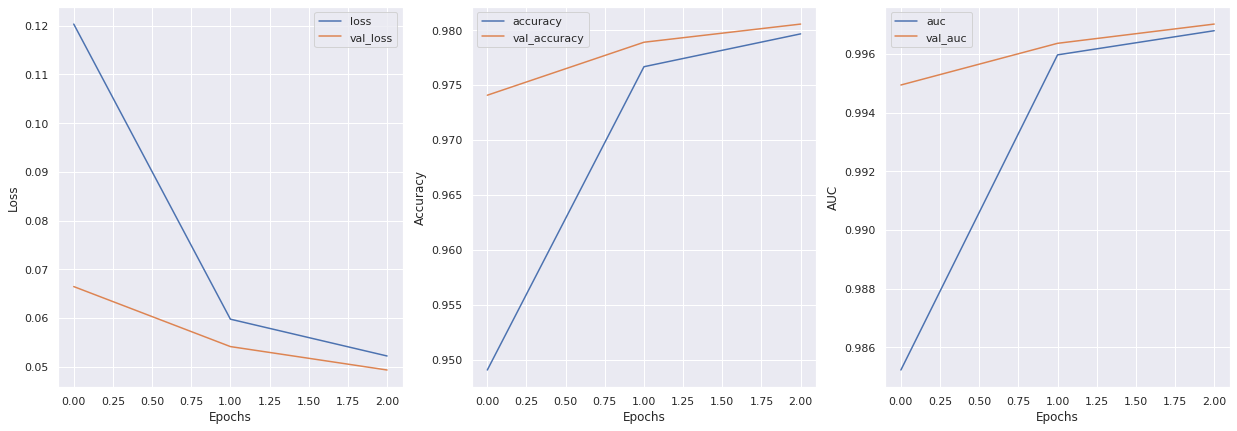

In [7]:
hist = history.history

plt.figure(figsize=(21,7))
plt.subplot(1, 3, 1)
plt.plot(range(config.EPOCHS), hist['loss'], label='loss')
plt.plot(range(config.EPOCHS), hist['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.plot(range(config.EPOCHS), hist['accuracy'], label='accuracy')
plt.plot(range(config.EPOCHS), hist['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.subplot(1, 3, 3)
plt.plot(range(config.EPOCHS), hist['auc'], label='auc')
plt.plot(range(config.EPOCHS), hist['val_auc'], label='val_auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='best')

plt.show()

In [8]:
tests = [ '''아무튼 동아시아에도 상투를 자르기 전에 내 목을 먼저 쳐라, 
예의의 나라가 어떻게 양이의 법도를 따르겠냐라며 엄청난 저항이 있었지만, 
결국 서구문명을 완전히 받아들이고 흡수했습니다.''',
    
    '''내가그린기린그림은긴기린그린그림이고, 
네가그린기린그림은길지않은기린그린그림이다.''',

    '''병원에 응급 환자가 실려 왔다. 클리블랜드에게 3쿼터 막판~4쿼터 초반 구간 0-24 런(RUN) 일방적인 
폭행을 당했던 휴스턴이다. 러셀 웨스트브룩, 클린트 카펠라 등 수련생들은 어찌할 바를 몰라
발을 동동 굴렀다. 여기서 전문의 털보 선생님 등장. "모두 물러나라. 내가 치료하겠다." 
환자는 '털보네이터'의 자상한 개인 전술 기반 연속 13득점 시술을 받은 후 기적적으로 소생했다. 
털보는 팀이 4쿼터 마지막 8분 구간에서 기록한 28득점 중 23득점을 생산한 후 유유히 퇴근한다.
(본인 20득점+AST 기반 동료 3점) 3점슛 10개 포함 55득점(FG 20/34)은 치료비다. ''',

    '''경기후 컨퍼런스 무리뉴 : 난 그런 기분이 들었어, 예전에 알렉스 퍼거슨 경이 
호랑이 얘기 한거 나는 기억하거든? 아마 이런 건 문화적인 것이겠지. 지성 팍과 
손, 둘다 감독으로서 지도하기 정말 좋은 선수들이야. 손흥민은 판타스틱해. 
나는 기뻐, 정말로! - 국뽕코인 탑승하는 무버지''']

# Remove whitespaces
tests = [''.join(t.split()) for t in tests]
encoded = [encode_string(t, config.CHR_TO_IDX) for t in tests]
encoded = pad_sequences(encoded, maxlen=config.MAX_TEXT_LEN, 
                        padding='post', truncating='post',
                        value=config.CHR_TO_IDX['<PAD>'])

probs = model.predict([encoded])

for i, t in enumerate(tests):
    print('#{}: '.format(i+1))
    for j, c in enumerate(t[:config.MAX_TEXT_LEN]):
        print(c, end='')
        if probs[i][j] >= 0.5:
            print(' ', end='')
    print('\n')

#1: 
아무튼 동아시아에도 상투를 자르기 전에 내목을 먼저 쳐라, 예의의 나라가 어떻게 양이의 법도를 따르겠냐라며 엄청난 저항이 있었지만, 결국 서구 문명을 완전히 받아들이고 흡수했습니다.

#2: 
내가 그린 기린 그림은 긴 기린 그린 그림이고, 네가 그린 기린 그림은 길지 않은 기린 그린 그림이다.

#3: 
병원에 응급 환자가 실려왔다. 클리블랜드에게 3쿼터 막판~4쿼터 초반구간 0-24런(RUN) 일방적인 폭행을 당했던 휴스턴이다. 러셀 웨스트브룩, 클린트 카펠라 등 수련생들은 어찌할 바를 몰라 발을 동동 굴렀다. 여기서 전문의 털보선생님 등장."모두 물러나라. 내가 치료하겠다." 환자는 '털보네이터'의 자상한 개인 전술 기반 연속 13득점 시술을 받은 후 기적적으로 소생했다. 털보는 팀이 4쿼터 마지막 8분 구간에서 기록한 28득점 중 23득점을 생산한 

#4: 
경기 후 컨퍼런스무리뉴 : 난 그런 기분이 들었어, 예전에 알렉스 퍼거슨 경이 호랑이 얘기한 거 나는 기억하거든? 아마 이런 건 문화적인 것이겠지. 지성팍과 손, 둘 다 감독으로서 지도하기 정말 좋은 선수들이야. 손흥민은 판타스틱해. 나는 기뻐, 정말로! - 국뽕코인 탑승하는 무버지

